# Homework 3

In class we have covered a lot of the theory behind transformers and how they can be used. Now it is finally time for you to start programming your own! I highly reccomend that you read the huggingface docs to learn more as you work through this. I will try to make it easy to follow along, but as a warning GPT alone will not save you if you have to debug code because we are using libraries to load our pretrained models that it doesn't have a full understanding of. Please ask us if you need any help. Hopefully this will get you started so you can finetune transformers for anything you can dream of!

In [ ]:
# FYI the accellerate -u is very important to avoid version issues with torch
!pip install transformers
!pip install accelerate -U

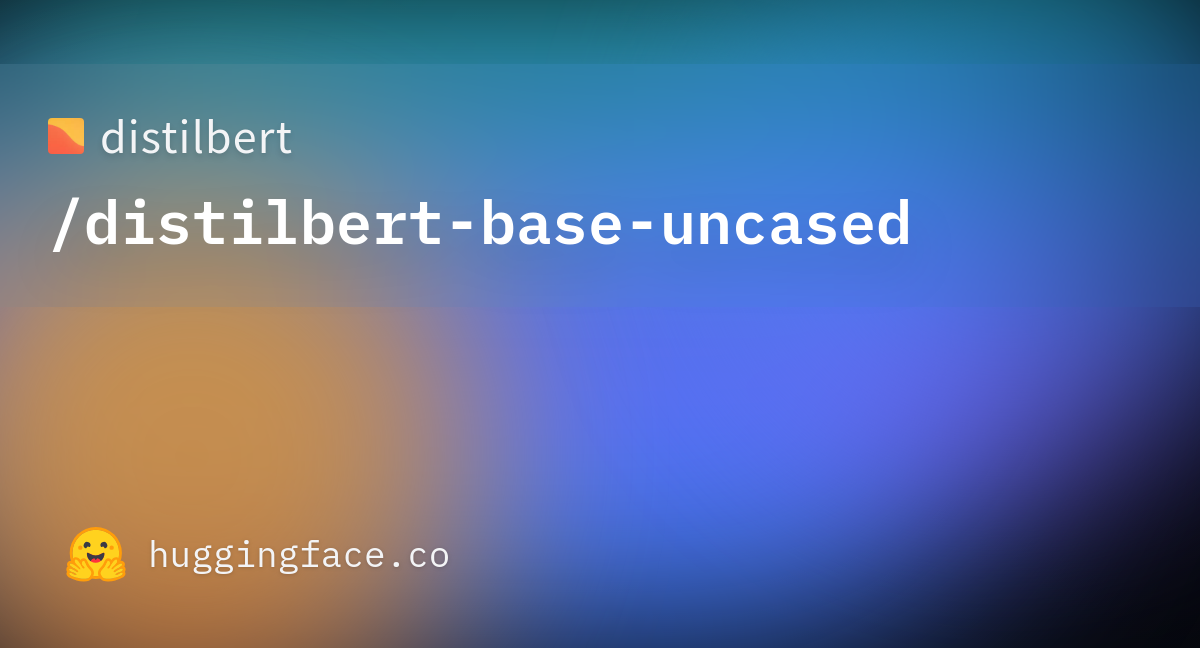

**OVERVIEW: In this homework our goal is to finetune a pretrained transformer so it can detect spam emails with high accuracy** Below we will walk you through the steps to design such a model. Not everything will be explicitly given and the goal of this assignment is to get you to read the huggingface documentation or even google to better understand our model and the libraries surrounding Huggingface and transformers in general


1. **First we are going to load our model**: In this case we will use distilbert-base-uncased-finetuned-sst-2-english. This is an encoder model we can use for classification. Don't worry well get to decoders soon after we cover them next class. Here is a link to the documentation I definitly reccomend reading through. Huggingface is the greatest weapon in our transformers arsonal so it is very good to learn how to use it. Here is a link to the model: https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english



In [ ]:
from transformers import DistilBertForSequenceClassification, AutoTokenizer
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer

# Load DistilBERT model and tokenizer filling out the code below based on the documentation HINT: Click on on use in transformers and the code will be there
model_name = # code unnessisary but I like to use it to store the string name to make the code cleaner
tokenizer = # code
model = # code

2. **Now we are going to load the data we are training on.** This is a dataset I stole from Kaggle and have saved as a csv (comma seperated value file). The csv has many columns but we don't need all of them. Remove all the colums we don't need using pandas (pd). **Additionally"** explain why you removed what you did in a comment below. Here is a link to pertinant docs if you are not familiar with pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

In [ ]:
#load test.csv
import pandas as pd
import numpy as np
import os

# Load the dataset into a pandas dataframe.
df = pd.read_csv("test.csv")


#TODO: Prepare the dataset so we just have the colums we want to train with remembering what type of model this is using pandas


# TODO: Explination Here


3. **Now we are going to "clean" the data.** In this case the data is already clean, but if it isn't it won't be able to encode the data and train on it so as a sanity check especially when you are learning we are going to make sure that our data is all of the right types so any errors in encoding is an encoder issue and not a data issue. This wasn't covered in class but should be quite easy to look up I just want you to think about debugging and testing more as later these issues can be very difficult to pin down.

In [ ]:
# Here I check if any rows have a nan values so I am 100% sure there should be no training errors (This would be very annoying to debug later if you found your own dataset)
nan_rows = df[df.isnull().T.any().T]
nan_rows

In [ ]:
# TODO: Make sure the inputs are of the right data types considering the model type (str/int)


4. **Now we are almost ready to put our training data into out model BUT, we still need to set our training and validation sets so we can assess our models imporvement AND we need to tokenize the input, which is the process of encoding the values** Remember that the transformer needs to encode the data beforeit can perform attention as words themselves are just words it needs their representation as a vector that includes position and numerical representations of the words meaning to actually understand what is happening to gain its understanding.

In [ ]:
from sklearn.model_selection import train_test_split

#TODO: Complete this line using the train_test_split function and set the test size to .21
train_texts, val_texts, train_labels, val_labels = #code

# Reset the index
train_texts, train_labels = train_texts.reset_index(drop=True), train_labels.reset_index(drop=True)
val_texts, val_labels = val_texts.reset_index(drop=True), val_labels.reset_index(drop=True)

5. **Now we are ready to encode our training and validaton datasets** Search up the tokenizer we are using. We defined it above so ctr-f your way back up there if you need to. The tokenizer should take 3 parameters and I'll give you 2 of them: truncation=True, padding=True. Now you just need to figure out the first parameter and tokenize both training and validation. HINT: what did we just prepare and it should be a list.

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

6. **Now lets create a class to put it all together that takes our encoded input and the last thing we need which is its label nicely formatted next to it.** This is what allows it to train for classification as of course we need the classifier 0-1 to represent the classification we want for spam or not. Here is a link that might help: https://discuss.huggingface.co/t/item-key-torch-tensor-val-idx-for-key-val-in-self-encodings-items-attributeerror-list-object-has-no-attribute-items/12695 NOTE the code here cannot be copy pasted it is close to our answer though. Use it as a guide but keep min mind what we want at each step

In [ ]:
import torch as pt

class SpamDataset(pt.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # TODO: finish this dictionary comprehention to get the correct tensors passed into our transformer.


    def __len__(self):
        return len(self.labels)


# TODO: Now create the train and val datasets with the class we created above. HINT look at the parameters SpamDataset has and think about what it does



7. **The next 2 cells are just preparing the trainer.** There are a lot of settings we can customize that have deep rooted implications in the training. You may not recognize some - we may to8uch on them later - but you should recognize the most important ones like epoch. Read the comments I added and look some of them up. After this we are training ready! Here is a link to the training documents from HuggingFace: https://huggingface.co/docs/transformers/main_classes/trainer and https://huggingface.co/docs/evaluate/en/transformers_integrations

In [ ]:
from sklearn.metrics import accuracy_score


def compute_metrics(eval_pred):
    # TODO: Look up on Hufggingface how to create a compute metrics function so we can return accuracy (using labels and predictions) and store the training information in a variable eval_pred


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    #TODO: figure out what 5 params we need here. There should be 5 and the last is how we compute the metrics later . . .
)

8. **Now we are ready to train!** We have already set all of the training parameters and encoded our text and labels so we can train our model! **PLEASE TRY TO USE COLLAB T4 (runtime --> change runtime type --> T4 TPU)
OR COLLAB IN GENERAL** If you don't have a good machine and run this locally it can take over an hour where as collab is under 4 minutes

In [ ]:
# TODO: Train the model (HINT: this is 1 short line of code just calling the trainer)


In [ ]:
#TODO use the evaluate method on the trainer to get and print the results. Feel free to look at Huggingface Docs


In [ ]:
# TODO: Save the model


In [ ]:
# TODO: Now to finish off I want you to load the model you trained and saved and write a fake spam email for it mthen have the model classify it


9. **Now its time for a challenge. It has come time to remove the training wheels and set you free!** Find a dataset online that has sentence pairs and finetune a transformer from huggingface (watch the size large transformers have a lot more values to update per epoch) to assess the similarity between the sentences. Make sure you are **Finetuning** and not just using a pretrained model or using transfer learning with classification neural network on top you should be **training the model itself**. Have some fun with this question and feel free to ask for help in the discord.

In [ ]:
# TODO: load your dataset AND exicute the first few rows so we can see what you are using



In [ ]:
# TODO: Follow the directions above and have some fun. This will be graded just on weither or not the transformer and dataset choices are rational and the code is actually finetuning you don't need to submit the dataset

